# Training Data Pipeline Notebook
## Date: 7/18/24
Author: Sylas Chacko

In [2]:
# Importing Packages

import numpy as np
import pandas as pd
import sklearn
import os
import PIL
from PIL import Image
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
from glob import glob
import shutil
from pathlib import Path
import imagesize
import cv2


### Splitting sample images into train and test splits. 

In [ ]:
# Path to the directory containing the images
image_dir = r'C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\images'

# Paths to the destination directories for train and test datasets
train_dir = r'C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\train'
test_dir = r'C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\test'

# Function to move images to specified directory
def move_images(file_list, destination):
    with open(file_list, 'r') as file:
        for line in file:
            image_name = line.strip()  # Assuming the images are PNG. Adjust if different.
            source_path = os.path.join(image_dir, image_name)
            destination_path = os.path.join(destination, image_name)
            if os.path.exists(source_path):
                shutil.move(source_path, destination_path)
            else:
                print(f"Image not found: {image_name}")

# Ensure the directories exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Paths to the text files containing the lists
train_list_path = r'C:\Users\sylas\OneDrive\Projects\medical_images\data\train_val_list.txt'
test_list_path = r'C:\Users\sylas\OneDrive\Projects\medical_images\data\test_list.txt'

# Move the images according to the lists
move_images(train_list_path, train_dir)
move_images(test_list_path, test_dir)

# Image Preprocessing Pipeline
- Normalizing Aspect Ratio
- Scaling of Images
- Reduction in Dimension
- Normalization of Image Inputs
- Augmentation of Image Data

### 1. Normalizing Aspect Ratio:

#### Steps: 
1. Visualize aspect ratio distribution
2. Modify images to chosen ratio

In [4]:
# Define the root directory containing the images
root = Path(r"C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\train")

# Get the list of image files with a .png extension
imgs = [img for img in root.iterdir() if img.suffix == ".png"]

# Initialize a dictionary to store image metadata
img_meta = {}

# Iterate through the images and collect their resolutions
for img_path in imgs:
    img_meta[str(img_path.name)] = imagesize.get(img_path)

# Convert the metadata dictionary to a DataFrame and compute the aspect ratio
img_meta_df = pd.DataFrame.from_dict(img_meta, orient='index', columns=['Width', 'Height']).reset_index()
img_meta_df.rename(columns={'index': 'FileName'}, inplace=True)
img_meta_df["Aspect Ratio"] = round(img_meta_df["Width"] / img_meta_df["Height"], 2)

# Print the total number of images and display the first few rows of the DataFrame
print(f'Total Number of Images in the dataset: {len(img_meta_df)}')
print(img_meta_df)


Total Number of Images in the dataset: 4313
              FileName  Width  Height  Aspect Ratio
0     00000017_001.png   1024    1024           1.0
1     00000030_001.png   1024    1024           1.0
2     00000040_003.png   1024    1024           1.0
3     00000042_002.png   1024    1024           1.0
4     00000057_001.png   1024    1024           1.0
...                ...    ...     ...           ...
4308  00030609_021.png   1024    1024           1.0
4309  00030650_002.png   1024    1024           1.0
4310  00030695_002.png   1024    1024           1.0
4311  00030786_005.png   1024    1024           1.0
4312  00030789_000.png   1024    1024           1.0

[4313 rows x 4 columns]


Since the aspect ratio is 1.0 for all images, and most neural networks expect a square shaped image, there is no reason to adjust the aspect ratio.

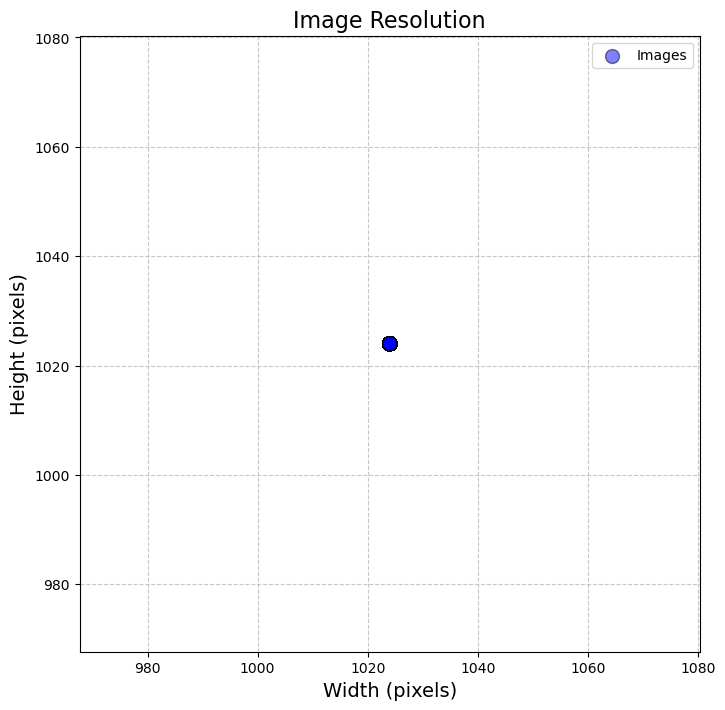

In [5]:
# Visualize Image Resolutions
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Scatter plot of image resolutions
points = ax.scatter(img_meta_df.Width, img_meta_df.Height, 
                    color='blue', alpha=0.5, 
                    s=img_meta_df["Aspect Ratio"]*100, 
                    edgecolor='k', label="Images")

# Adding title and labels
ax.set_title("Image Resolution", size=16)
ax.set_xlabel("Width (pixels)", size=14)
ax.set_ylabel("Height (pixels)", size=14)

# Optional: Adding a grid for better readability
ax.grid(True, linestyle='--', alpha=0.7)

# Adding a legend
ax.legend()

# Show the plot
plt.show()

### 2. Scaling of Images

#### Steps: 
1. Add new photos to data_preprocessing\s_train_pipeline\train_scaling directory
2. Optimize script so that the resolution changes can be streamlined

In [2]:
# Define paths
input_dir = Path(r"C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\train")
output_dir = Path(r"C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_scaling")

# Define the desired output size (you can adjust this)
output_size = (224, 224)
output_dir.mkdir(parents=True, exist_ok=True)

# Delete any previous images in the output directory
for file in output_dir.glob("*.png"):
    file.unlink()

# Iterate over all images in the input directory
for img_path in input_dir.glob("*.png"):
    # Read the image
    img = cv2.imread(str(img_path))

    # Resize the image
    resized_img = cv2.resize(img, output_size, interpolation=cv2.INTER_AREA)

    # Save the resized image to the output directory
    output_path = output_dir / img_path.name
    cv2.imwrite(str(output_path), resized_img)

print(f"Resized images saved to {output_dir} with resolution {output_size[0]}x{output_size[1]} pixels.")


Resized images saved to C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_scaling with resolution 224x224 pixels.


### 3. Reduction in Dimension

#### Steps: 
1. 

In [3]:
# Define paths
input_dir = Path(r"C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_scaling")
output_dir = Path(r"C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_dimension")

# Create the output directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)

# Delete any previous images in the output directory
for file in output_dir.glob("*.png"):
    file.unlink()

# Iterate over all images in the input directory
for img_path in input_dir.glob("*.png"):
    # Read the image
    img = cv2.imread(str(img_path))
    
    # Convert to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Save the grayscale image to the output directory
    output_path = output_dir / img_path.name
    cv2.imwrite(str(output_path), gray_img)

print(f"Grayscale images saved to {output_dir}.")


Grayscale images saved to C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_dimension.


### 4. Normalization of Image Inputs

#### Steps: 
1. 

In [4]:
# Define paths
input_dir = Path(r"C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_dimension")
output_dir = Path(r"C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_norm_input")

# Create the output directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)

# Delete any previous images in the output directory
for file in output_dir.glob("*.png"):
    file.unlink()

# Iterate over all images in the input directory
for img_path in input_dir.glob("*.png"):
    # Read the image
    img = cv2.imread(str(img_path))
    
    # Convert image to float32 for accurate division
    img = img.astype(np.float32)
    
    # Normalize the image to the range [0, 1]
    img_normalized = img / 255.0
    img_to_save = (img_normalized * 255).astype(np.uint8)
    
    # Save the normalized image to the output directory
    output_path = output_dir / img_path.name
    cv2.imwrite(str(output_path), img_to_save)

print(f"Normalized images saved to {output_dir} with pixel values in the range [0, 1].")


Normalized images saved to C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_norm_input with pixel values in the range [0, 1].


### 5. Augmentation of Image Data

#### Steps: 
1. 

In [5]:
# Define paths
input_dir = Path(r"C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_norm_input")
output_dir_png = Path(r"C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_augmentation")
output_dir_npy = Path(r"C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\s_train_final")

# Create the output directories if they don't exist
output_dir_png.mkdir(parents=True, exist_ok=True)
output_dir_npy.mkdir(parents=True, exist_ok=True)

# Delete any previous images in the output directories
for file in output_dir_png.glob("*.png"):
    file.unlink()

for file in output_dir_npy.glob("*.npy"):
    file.unlink()

def augment_image(image):
    augmented_images = []
    
    # Original image
    augmented_images.append(image)
    
    # Rotate image by 90, 180, and 270 degrees
    for angle in [90, 180, 270]:
        rotated_img = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE if angle == 90 else cv2.ROTATE_180 if angle == 180 else cv2.ROTATE_90_COUNTERCLOCKWISE)
        augmented_images.append(rotated_img)
    
    # Flip image horizontally and vertically
    flip_h = cv2.flip(image, 1)
    flip_v = cv2.flip(image, 0)
    augmented_images.append(flip_h)
    augmented_images.append(flip_v)
    
    return augmented_images

for img_path in input_dir.glob("*.png"):
    img = cv2.imread(str(img_path))
    augmented_images = augment_image(img)
    
    for i, aug_img in enumerate(augmented_images):
        # Save as PNG
        output_path_png = output_dir_png / f"{img_path.stem}_aug_{i}.png"
        cv2.imwrite(str(output_path_png), aug_img)

        # Save as NPY
        output_path_npy = output_dir_npy / f"{img_path.stem}_aug_{i}.npy"
        np.save(output_path_npy, aug_img.astype(np.float32) / 255.0)  # Save the normalized image in .npy format

print(f"Augmented images saved to {output_dir_png} as PNG and to {output_dir_npy} as NPY.")


Augmented images saved to C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\train_augmentation as PNG and to C:\Users\sylas\OneDrive\Projects\medical_images\data\sample\s_train_pipeline\s_train_final as NPY.
